# CNN - 이상감지

In [1]:
# 모듈 로딩(1)
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from collections import Counter

In [2]:
# 모듈 로딩(2)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, Flatten,Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense

In [3]:
df = pd.read_csv('./bus_getonoff_sum.csv')
# df

***

In [4]:
df['get_num'].value_counts()

2    626429
0    225248
1    131447
Name: get_num, dtype: int64

***

In [5]:
df['action_num'].value_counts()
# 약 90만개의 데이터가 있음

3    486990
1    279102
0    108011
5     99613
4      4799
7      2641
2      1631
6       337
Name: action_num, dtype: int64

In [6]:
df1 = pd.read_csv('./bus_state.csv')

In [7]:
df1['action_num'].value_counts()

3    14756
0     9412
1     8111
4     4718
5     3791
7     2641
6      327
2      150
Name: action_num, dtype: int64

In [8]:
# 6k 10
# 2r 1100 (x)
# 0st, 1w, 3s d, 5g h 다
# 4l d ,7p =
# ===== 
# 6(kick)은 그다지 늘어나지 않음
# 2(run)은 그렇게 많지는 않을 것임
# 4(lay down)과 7(punch)는 거의 변동x
# 0(stand), 1(walk), 3(sit down), 5(grab handle)은 많이 늘어남
# 효용이 있을지는 모르겠으나 일단 ㄱ

In [9]:
df.head()

,bbox,keypoints,action,get_on,get_off,get_num,action_num
0,"[974, 266, 1471, 1077]","[1074, 1020, 2, 1111, 923, 2, 1151, 752, 2, 12...",stand,True,False,1,0
1,"[1017, 224, 1452, 1060]","[1094, 918, 2, 1131, 802, 2, 1185, 643, 2, 131...",stand,True,False,1,0
2,"[1007, 224, 1445, 1049]","[1085, 909, 2, 1118, 787, 2, 1174, 634, 2, 129...",stand,True,False,1,0
3,"[1007, 222, 1428, 1049]","[1082, 908, 2, 1113, 786, 2, 1155, 627, 2, 127...",stand,True,False,1,0
4,"[995, 220, 1421, 1044]","[1071, 904, 2, 1102, 782, 2, 1144, 623, 2, 127...",stand,True,False,1,0


In [10]:
df['keypoints']

0         [1074, 1020, 2, 1111, 923, 2, 1151, 752, 2, 12...
1         [1094, 918, 2, 1131, 802, 2, 1185, 643, 2, 131...
2         [1085, 909, 2, 1118, 787, 2, 1174, 634, 2, 129...
3         [1082, 908, 2, 1113, 786, 2, 1155, 627, 2, 127...
4         [1071, 904, 2, 1102, 782, 2, 1144, 623, 2, 127...
                                ...                        
983119    [997, 1077, 0, 997, 1010, 0, 1016, 1042, 0, 88...
983120    [1458, 636, 1, 1483, 581, 1, 1494, 658, 1, 141...
983121    [1446, 632, 1, 1471, 577, 1, 1482, 654, 1, 139...
983122    [1373, 670, 1, 1372, 585, 1, 1418, 523, 2, 133...
983123    [1331, 670, 1, 1337, 561, 1, 1381, 437, 1, 129...
Name: keypoints, Length: 983124, dtype: object

In [11]:
# df[df['keypoints']==[x_test[0].tolist()]]

In [12]:
# 열 타입변경
# keypoints와 bbox는 문자열 값으로 저장되어 있어서 배열 형태로 바꾸어 주어야 할 필요성이 있어보여서 이 코드를 만듬
keypoins_arr=[]
bbox_arr=[]

for i in range(len(df)): # 테이블 행 수 만큼 for문 돌림
    bbox_arr.append(np.array(list(map(int,df.bbox[i].strip('[').strip(']').split(','))))) 
    keypoins_arr.append(np.array(list(map(int,df.keypoints[i].strip('[').strip(']').split(',')))))
    
# 배열 형태로 값들이 저장됨
df.bbox=bbox_arr
df.keypoints=keypoins_arr

In [43]:
keypoints = np.array(list(df.keypoints)).reshape(-1,16,1,3)

In [44]:
print(type(df.keypoints))
print(keypoints.shape)

<class 'pandas.core.series.Series'>
(983124, 16, 1, 3)


In [45]:
# 'action_num'을 배열로만 넘겨주면 되겠지
y = np.array(df.action_num)
y.shape

(983124,)

In [46]:
# train과 test 나누기
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(keypoints, y, test_size=0.2, random_state=42)

In [47]:
# 스케일링
x_train = x_train/255.0
x_test = x_test/255.0

***

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 1. MNIST 데이터셋 불러오기
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 2. 데이터 전처리하기
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

# 3. 합성곱 신경망 구성하기
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.summary()

# 4. Dense 층 추가하기
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

# 5. 모델 컴파일하기
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#-> compile() 메서드를 이용해서 옵티마이저, 손실 함수, 지표를 각각 설정

# 6. 훈련하기
model.fit(train_images, train_labels, epochs=5)

# 7. 모델 평가하기
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

## 단순한 Dense 층으로만 이루어진 신경망으로 학습한 경우의 정확도인 0.9802에 비해 더 높은 정확도

In [ ]:
# 합성곱 신경망과 Dense 층을 구성하는 또 다른 방식
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

***

In [49]:
# 경고무시
import warnings
warnings.filterwarnings(action='ignore')

# model = Sequential()
# model.add(Conv2D(12, kernel_size=(5, 5), activation='relu', input_shape=(120, 60, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(20, kernel_size=(4, 4), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(4, activation='softmax'))

# batch normalization : 
# 입력값 x를 평균 0, 분산 1로 표준화하여 활성화 함수로 전달하고 활성화 함수 출력값을 분포를 고르게 합니다.
# x를 표준화 하는 과정에서 배치 사이즈 단위로 평균과 분산값을 계산하는데요.
# 어떤 배치 사이즈를 선택하느냐에 따라 평균과 분산값이 달라지므로 성능에 영향을 미치게 됩니다.

# dropout -> 회귀, 과적합 해소

# CNN2d
model = Sequential()          
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', input_shape=(16,1,3)))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# model.add(Conv2D(filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# model.add(MaxPooling2D(pool_size = (2,1)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# Flatten (펴주기)
model.add(Flatten())

# dense layer with 50 neurons
# model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
# model.add(Dropout(0.5))

# final layer with 8 neurons to classify the instances
model.add(Dense(8, activation='softmax'))

# model 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 1, 32)         896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 1, 32)         0         
 2D)                                                             
                                                                 
 activation_3 (Activation)   (None, 8, 1, 32)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 1, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 1, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 1, 64)        

In [44]:
# with tf.device("/device:CPU:0"):
#     # model.fit(X_train, y_train, epochs=10)
#     model.fit(x_train, y_train, validation_split=0.2, epochs=5)

Epoch 1/10
31460/31460 [==============================] - 147s 5ms/step - loss: 0.2840 - accuracy: 0.8986 - val_loss: 0.2910 - val_accuracy: 0.8959
Epoch 2/10
31460/31460 [==============================] - 163s 5ms/step - loss: 0.2812 - accuracy: 0.8994 - val_loss: 0.2838 - val_accuracy: 0.8969
Epoch 3/10
31460/31460 [==============================] - 169s 5ms/step - loss: 0.2787 - accuracy: 0.9003 - val_loss: 0.2781 - val_accuracy: 0.9010
Epoch 4/10
31460/31460 [==============================] - 175s 6ms/step - loss: 0.2768 - accuracy: 0.9015 - val_loss: 0.2875 - val_accuracy: 0.8969
Epoch 5/10
31460/31460 [==============================] - 176s 6ms/step - loss: 0.2751 - accuracy: 0.9021 - val_loss: 0.2740 - val_accuracy: 0.9052
Epoch 6/10
31460/31460 [==============================] - 174s 6ms/step - loss: 0.2730 - accuracy: 0.9024 - val_loss: 0.2853 - val_accuracy: 0.8993
Epoch 7/10
31460/31460 [==============================] - 165s 5ms/step - loss: 0.2720 - accuracy: 0.9031 - val_

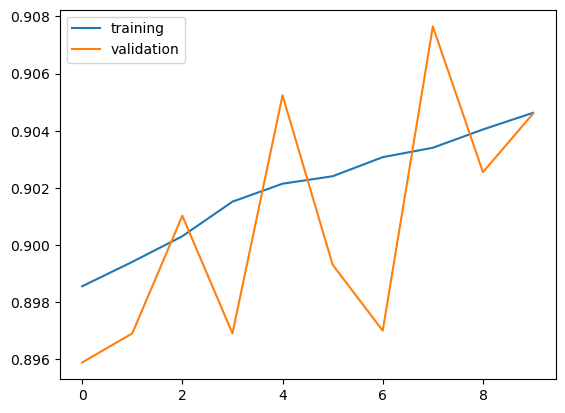

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
# 검증 데이터에 대한 loss값 3번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=3)

# result = model.fit(x_train, y_train, epochs=3, batch_size = 10,
#                    validation_data=(X_test, y_test), callbacks=[stopCB])
# epochs = 1      : 처음~끝까지 학습 횟수가 1이라는 것

#########################################################################

with tf.device("/device:GPU:0"):
    # model.fit(X_train, y_train, epochs=10)
    history = model.fit(x_train, y_train,epochs=10, batch_size = 20,
                        validation_split=0.2, callbacks=[stopCB])
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training', 'validation'], loc = 'upper left')
    plt.show()


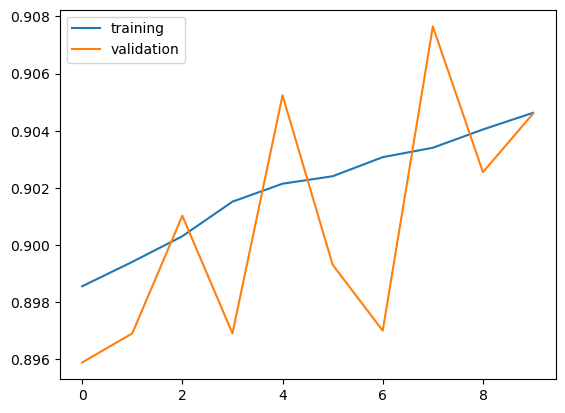

In [52]:
# history = model.fit(x_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 10, verbose = 0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [53]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 31460}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

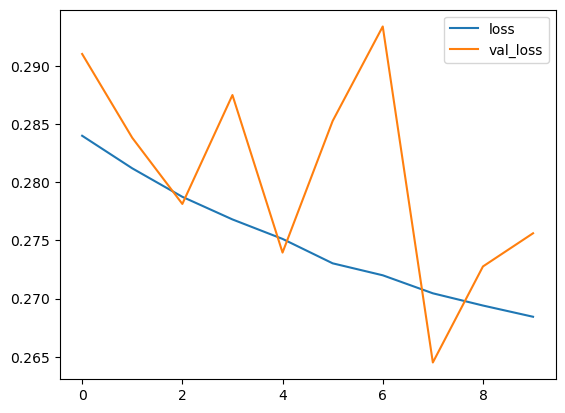

In [55]:
### 시각화
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='loss')
# plt.plot(result.epoch, result.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
- scaling 해서 해보기
- 전체 vs. 26만개

In [66]:
# 평가
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results)

6145/6145 [==============================] - 16s 3ms/step - loss: 0.3137 - accuracy: 0.8857
Test accuracy:  [0.3136594593524933, 0.8857113718986511]


In [47]:
pre_y = model.predict(x_test[0].reshape(-1,16,1,3))

1/1 [==============================] - 0s 156ms/step


In [51]:
pre_y

array([[1.4672713e-01, 8.4683043e-01, 4.0486781e-03, 1.2188915e-04,
        4.0519667e-06, 7.1546972e-05, 2.1933174e-05, 2.1743134e-03]],
      dtype=float32)

In [48]:
pre_y.round(2), pre_y.shape

(array([[0.15, 0.85, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]], dtype=float32),
 (1, 8))

In [67]:
x_test[0]
# len(x_test[0])

array([[[741, 334,   2]],

       [[739, 275,   2]],

       [[751, 214,   2]],

       [[719, 218,   2]],

       [[707, 279,   2]],

       [[703, 339,   2]],

       [[735, 221,   2]],

       [[735, 163,   2]],

       [[729, 131,   2]],

       [[727, 116,   2]],

       [[732, 190,   1]],

       [[748, 176,   2]],

       [[749, 141,   2]],

       [[706, 152,   2]],

       [[701, 184,   2]],

       [[713, 192,   1]]])

In [ ]:
741, 334, 2, 739, 275, 2, 751, 214, 2, 719, 218, 2, 707, 279, 2, 703, 339, 2, 735, 221, 2

In [ ]:
# 1) 전체 vs 다운 샘플링 
# 2) 불균형 해소
# 3) 교차검증